In [21]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import product
from perlin_numpy import generate_perlin_noise_2d
from scipy.interpolate import griddata
from scipy.stats import percentileofscore
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [22]:
np.random.seed(1)

obj = "crosslegtable"

m = 5
n = 100

percentile = 50

iterations = 10

laplace_alpha = 0

In [23]:
ackley = lambda X, Y: -(20 * (1 - np.exp(-0.2 * np.sqrt(0.5 * (X**2 + Y**2)))) - np.exp(0.5 * (np.cos(2 * np.pi * X) + np.cos(2 * np. pi * Y))) + np.exp(1))
beale = lambda X, Y: -((1.5 - X + X * Y)**2 + (2.25 - X + X * Y**2)**2 + (2.625 - X + X * Y**3)**2)
bird = lambda X, Y: -(np.sin(X) * np.exp((1 - np.cos(Y))**2) + np.cos(Y) * np.exp((1 - np.sin(X))**2) + (X - Y)**2)
booth = lambda X, Y: -((X + 2 * Y - 7)**2 + (2 * X + Y - 5)**2)
bukin4 = lambda X, Y: -(100 * Y**2 + 0.01 * np.abs(X + 10))
bukin6 = lambda X, Y: -(100 * np.sqrt(abs(Y - 0.01 * X**2)) + 0.01 * np.abs(X + 10))
carromtable = lambda X, Y: ((np.cos(X) * np.cos(Y) * np.exp(np.abs(1 - np.sqrt(X ** 2 + Y ** 2) / np.pi)))**2) / 30
chichinadze = lambda X, Y: -(X**2 - 12 * X + 11 + 10 * np.cos(np.pi * X / 2) + 8 * np.sin(5 * np.pi * X / 2) - 1 / np.sqrt(5) * np.exp(-((Y - 0.5)**2) / 2))
crossfunc = lambda X, Y: -(np.abs(np.sin(X) * np.sin(Y) * np.exp(np.abs(100 - np.sqrt(X**2 + Y**2) / np.pi))) + 1)**-0.1
crossintray = lambda X, Y: 0.0001 * (np.abs(np.sin(X) * np.sin(Y) * np.exp(np.abs(100 - np.sqrt(X**2 + Y**2) / np.pi))) + 1)**0.1
crosslegtable = lambda X, Y: (np.abs(np.sin(X) * np.sin(Y) * np.exp(np.abs(100 - np.sqrt(X**2 + Y**2) / np.pi))) + 1)**-0.1
crownedcross = lambda X, Y: -0.0001 * (np.abs(np.sin(X) * np.sin(Y) * np.exp(np.abs(100 - np.sqrt(X**2 + Y**2) / np.pi))) + 1)**0.1
cube = lambda X, Y: np.tile(-np.sum(100 * (Y - X**3)**2 + (1 - X)**2, axis=0), (X.shape[0], 1))
easom = lambda X, Y: np.cos(X) * np.cos(Y) * np.exp(-((X - np.pi)**2 + (Y - np.pi)**2))
eggholder = lambda X, Y: np.tile(-np.sum(-(Y + 47) * np.sin(np.sqrt(np.abs(Y + X / 2 + 47))) - X * np.sin(np.sqrt(np.abs(X - (Y + 47)))), axis=0), (X.shape[0], 1))
giunta = lambda X, Y: np.tile(-(0.6 + np.sum(np.sin(16 * (X / 15 - 1) + Y) + np.sin(16 * (X / 15 - 1) + Y)**2 + np.sin(4 * 16 * (X / 15 - 1) + Y) / 50, axis=0)), (X.shape[0], 1))
goldsteinprice = lambda X, Y: -(1 + (X + Y + 1)**2 * (19 - 14 * X + 3 * X**2 - 14 * Y + 6 * X * Y + 3 * Y**2)) * (30 + (2 * X - 3 * Y)**2 * (18 - 32 * X + 12 * X**2 + 48 * Y - 36 * X * Y + 27 * Y**2))
griewank = lambda X, Y: -((X**2 + Y**2) / 200 - np.cos(X) * np.cos(Y / np.sqrt(2)) + 1)
himmelblau = lambda X, Y: -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)
holdertable = lambda X, Y: np.abs(np.sin(X) * np.cos(Y) * np.exp(np.abs(1 - np.sqrt(X**2 + Y**2) / np.pi)))
leon = lambda X, Y: -(100 * (Y - X**3)**2 + (1 - X)**2)
levi13 = lambda X, Y: -(np.sin(3 * np.pi * X)**2 + (X - 1)**2 * (1 + np.sin(3 * np.pi * Y)**2) + (Y - 1)**2 * (1 + np.sin(2 * np.pi * Y)**2))
matyas = lambda X, Y: -(0.26 * (X**2 + Y**2) - 0.48 * X * Y)
mccormick = lambda X, Y: -(np.sin(X + Y) + (X - Y)**2 - 1.5 * X + 2.5 * Y + 1)
modschaffer1 = lambda X, Y: -(0.5 + (np.sin(X**2 + Y**2)**2 - 0.5) / (1 + 0.001 * (X**2 + Y**2))**2)
modschaffer2 = lambda X, Y: -(0.5 + (np.sin(X**2 - Y**2)**2 - 0.5) / (1 + 0.001 * (X**2 + Y**2))**2)
modschaffer3 = lambda X, Y: -(0.5 + (np.sin(np.cos(np.abs(X**2 - Y**2)))**2 - 0.5) / (1 + 0.001 * (X**2 + Y**2))**2)
modschaffer4 = lambda X, Y: -(0.5 + (np.cos(np.sin(np.abs(X**2 - Y**2)))**2 - 0.5) / (1 + 0.001 * (X**2 + Y**2))**2)
penholder = lambda X, Y: np.exp(-(np.abs(np.cos(X) * np.cos(Y) * np.exp(np.abs(1 - np.sqrt(X**2 + Y**2) / np.pi))))**-1)
perlin = lambda X, Y: generate_perlin_noise_2d((X.shape[0], X.shape[1]), (2, 2))
rastrigin = lambda X, Y: -(X**2 + Y**2 - 10 * np.cos(2 * np.pi * X) - 10 * np.cos(2 * np.pi * Y) + 2)
rosenbrock = lambda X, Y: np.tile(-np.sum(100 * (Y - X**2)**2 + (1 - X)**2, axis=0), (X.shape[0], 1))
schweffel = lambda X, Y: X * np.sin(np.sqrt(np.abs(X))) + Y * np.sin(np.sqrt(np.abs(Y)))
sinenvsin = lambda X, Y: np.tile(-np.sum((np.sin(np.sqrt(X**2 + Y**2))**2 - 0.5) / (1 + 0.001 * (X**2 + Y**2))**2 + 0.5, axis=0), (X.shape[0], 1))
sixhumpcamel = lambda X, Y: -((4 - 2.1 * X**2 + X**4 / 3) * X**2 + X * Y + (4 * Y**2 - 4) * Y**2)
testtubeholder = lambda X, Y: 4 * np.abs(np.sin(X) * np.cos(Y) * np.exp(np.abs(np.cos((X**2 + Y**2) / 200))))
threehumpcamel = lambda X, Y: -(2 * X**2 - 1.05 * X**4 + X**6 / 6 + X * Y + Y**2)
zettl = lambda X, Y: -((X**2 + Y**2 - 2 * X)**2 + X / 4)

def gaussian_min_max(X, Y):
    Z = np.zeros_like(X)

    for i, j in np.ndindex(Z.shape):
        Z[i, j] = np.min(np.exp(-(X[i, j]**2 + Y[i, j]**2 + np.linspace(-1, 1, 100)[:, np.newaxis]**2) / 2) / np.sqrt(2 / np.pi)**3)

    return Z

def helicalvally_min_max(X, Y):
    Z = np.zeros_like(X)

    for i, j in np.ndindex(Z.shape):
        Z[i, j] = np.min(-(100 * ((Z[i, j] - 10 * np.arctan2(Y[i, j], X[i, j]) / 2 / np.pi)**2 + (np.sqrt(X[i, j]**2 + Y[i, j]**2) - 1)**2) + Z[i, j]**2))

    return Z

def logarithmic_min_max(X, Y):
    Z = np.zeros_like(X)

    for i, j in np.ndindex(Z.shape):
        Z[i, j] = X[i, j]**2 * np.log((X[i, j] - Y[i, j] + Z[i, j])**2 + 1)

    return Z

objectives = {
    "ackley": {
        "func": ackley,
        "bounds": [(-35, 35)] * 2
    },
    "beale": {
        "func": beale,
        "bounds": [(-4.5, 4.5)] * 2
    },
    "bird": {
        "func": bird,
        "bounds": [(-2 * np.pi, 2 * np.pi)] * 2
    },
    "booth": {
        "func": booth,
        "bounds": [(-10, 10)] * 2
    },
    "bukin4": {
        "func": bukin4,
        "bounds": [(-15, 5), (-3, 3)]
    },
    "bukin6": {
        "func": bukin6,
        "bounds": [(-15, 5), (-3, 3)]
    },
    "carromtable": {
        "func": carromtable,
        "bounds": [(-10, 10)] * 2
    },
    "chichinadze": {
        "func": chichinadze,
        "bounds": [(-30, 30)] * 2
    },
    "crossfunc": {
        "func": crossfunc,
        "bounds": [(-10, 10)] * 2
    },
    "crossintray": {
        "func": crossintray,
        "bounds": [(-10, 10)] * 2
    },
    "crosslegtable": {
        "func": crosslegtable,
        "bounds": [(-10, 10)] * 2
    },
    "crownedcross": {
        "func": crownedcross,
        "bounds": [(-10, 10)] * 2
    },
    "cube": {
        "func": cube,
        "bounds": [(-5, 5)] * 2
    },
    "easom": {
        "func": easom,
        "bounds": [(-100, 100)] * 2
    },
    "eggholder": {
        "func": eggholder,
        "bounds": [(-512, 512)] * 2
    },
    "gaussian_min_max": {
        "func": gaussian_min_max,
        "bounds": [(-1, 1)] * 2
    },
    "giunta": {
        "func": giunta,
        "bounds": [(-1, 1)] * 2
    },
    "goldsteinprice": {
        "func": goldsteinprice,
        "bounds": [(-2, 2)] * 2
    },
    "griewank": {
        "func": griewank,
        "bounds": [(-100, 100)] * 2
    },
    "helicalvally_min_max": {
        "func": helicalvally_min_max,
        "bounds": [(-5, 5)] * 2
    },
    "himmelblau": {
        "func": himmelblau,
        "bounds": [(-5, 5)] * 2
    },
    "holdertable": {
        "func": holdertable,
        "bounds": [(-10, 10)] * 2
    },
    "leon": {
        "func": leon,
        "bounds": [(-1.2, 1.2)] * 2
    },
    "levi13": {
        "func": levi13,
        "bounds": [(-10, 10)] * 2
    },
    "logarithmic_min_max": {
        "func": logarithmic_min_max,
        "bounds": [(1, 2)] * 2
    },
    "matyas": {
        "func": matyas,
        "bounds": [(-10, 10)] * 2
    },
    "mccormick": {
        "func": mccormick,
        "bounds": [(-1.5, 4), (-3, 4)]
    },
    "modschaffer1": {
        "func": modschaffer1,
        "bounds": [(-100, 100)] * 2
    },
    "modschaffer2": {
        "func": modschaffer2,
        "bounds": [(-100, 100)] * 2
    },
    "modschaffer3": {
        "func": modschaffer3,
        "bounds": [(-100, 100)] * 2
    },
    "modschaffer4": {
        "func": modschaffer4,
        "bounds": [(-100, 100)] * 2
    },
    "penholder": {
        "func": penholder,
        "bounds": [(-11, 11)] * 2
    },
    "perlin": {
        "func": perlin,
        "bounds": [(-1, 1)] * 2
    },
    "rastrigin": {
        "func": rastrigin,
        "bounds": [(-5.12, 5.12)] * 2
    },
    "rosenbrock": {
        "func": rosenbrock,
        "bounds": [(-100, 100)] * 2
    },
    "schweffel": {
        "func": schweffel,
        "bounds": [(-500, 500)] * 2
    },
    "sinenvsin": {
        "func": sinenvsin,
        "bounds": [(-100, 100)] * 2
    },
    "sixhumpcamel": {
        "func": sixhumpcamel,
        "bounds": [(-5, 5)] * 2
    },
    "testtubeholder": {
        "func": testtubeholder,
        "bounds": [(-10, 10)] * 2
    },
    "threehumpcamel": {
        "func": threehumpcamel,
        "bounds": [(-5, 5)] * 2
    },
    "zettl": {
        "func": zettl,
        "bounds": [(-5, 5)] * 2
    }
}

In [24]:
obj = list(objectives.keys())[-1] if obj is None else obj

xy_range = objectives[obj]["bounds"]

X = np.arange(*xy_range[0], ((xy_range[0][1] - xy_range[0][0]) / 100))
Y = np.arange(*xy_range[1], ((xy_range[1][1] - xy_range[1][0]) / 100))
X, Y = np.meshgrid(X, Y)
Z = objectives[obj]["func"](X, Y)

z_range = (np.floor(np.min(Z)) - 1, np.ceil(np.max(Z)) + 1)

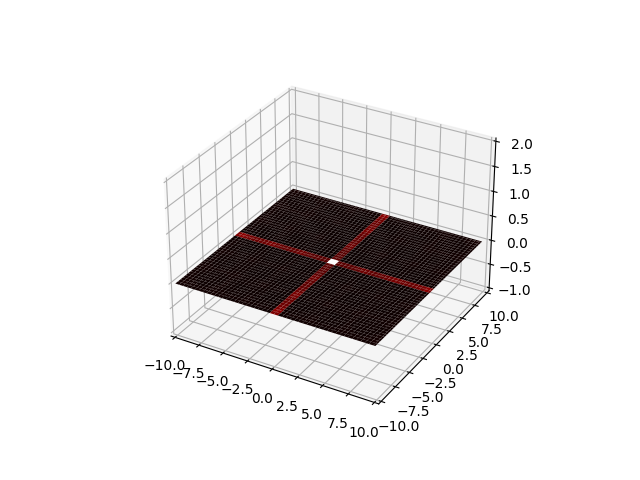

In [25]:
%matplotlib widget

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(X, Y, Z, cmap="hot")

ax.set_xlim(*xy_range[0])
ax.set_ylim(*xy_range[1])
ax.set_zlim(*z_range)

plt.savefig("baseline.png")
plt.show()

In [26]:
ran_err = lambda n, x: np.random.normal(0, x, n)
sys_err = lambda n, z: z**2

In [27]:
df = pd.DataFrame(np.random.randint(100, size=(m, 2)))

df.columns = ["i", "j"]

df["x"] = X[0, df["i"]]
df["y"] = Y[df["j"], 0]
df["z"] = Z[df["i"], df["j"]] + ran_err(m, 0.05)

for idx in range(1, iterations + 1):
    krnl = RBF(length_scale=1)
    model = GaussianProcessRegressor(kernel=krnl, normalize_y=False, random_state=3, alpha=0.001)

    tmp_df = pd.DataFrame(np.random.randint(100, size=(n, 2)))

    tmp_df.columns = ["i", "j"]

    tmp_df["x"] = X[0, tmp_df["i"]]
    tmp_df["y"] = Y[tmp_df["j"], 0]
    tmp_df["z"] = Z[tmp_df["i"], tmp_df["j"]] + sys_err(n, Z[tmp_df["i"], tmp_df["j"]])

    model.fit(tmp_df[["x", "y"]], tmp_df["z"])

    pred = model.predict(tmp_df[["x", "y"]])

    z = griddata((tmp_df["x"], tmp_df["y"]), pred, (X.T, Y.T), method="linear", fill_value=z_range[0])

    tmp_df = pd.DataFrame(list(product(range(100), range(100))), columns=["i", "j"])

    tmp_df["x"] = X[0, tmp_df["i"]]
    tmp_df["y"] = Y[tmp_df["j"], 0]
    tmp_df["z"] = Z[tmp_df["i"], tmp_df["j"]] + ran_err(10000, 0.05)

    mag = z[tmp_df["i"], tmp_df["j"]]

    p = mag - z.min() + laplace_alpha

    p = np.where(p > np.percentile(p, percentile), p, 0)

    p /= p.sum()

    tmp_df = tmp_df.loc[np.random.choice(tmp_df.index, size=m, p=p, replace=False)]

    df = pd.concat([df, tmp_df], ignore_index=True)

krnl = RBF(length_scale=1)
model = GaussianProcessRegressor(kernel=krnl, normalize_y=False, random_state=3, alpha=0.001)

model.fit(df[["x", "y"]], df["z"])

GaussianProcessRegressor(alpha=0.001, kernel=RBF(length_scale=1),
                         random_state=3)

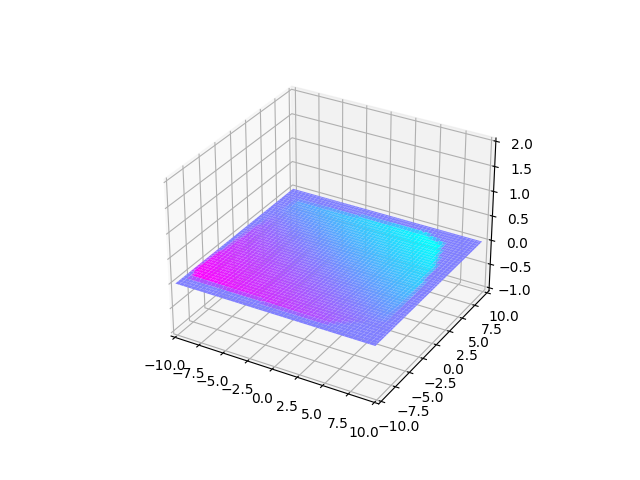

In [28]:
%matplotlib widget

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

pred = model.predict(df[["x", "y"]])

z = griddata((df["x"], df["y"]), pred, (X.T, Y.T), method="linear", fill_value=(z_range[0] + 1))

ax.plot_surface(X, Y, z, cmap="cool")

ax.set_xlim(*xy_range[0])
ax.set_ylim(*xy_range[1])
ax.set_zlim(*z_range)

plt.savefig("generated.png")
plt.show()

Predicted maximum: 9.971196413727484e-05 at (8, 3)
Actual maximum: 0.022230188195146005 at (50, 50)
RMSE: 0.018277479141078246


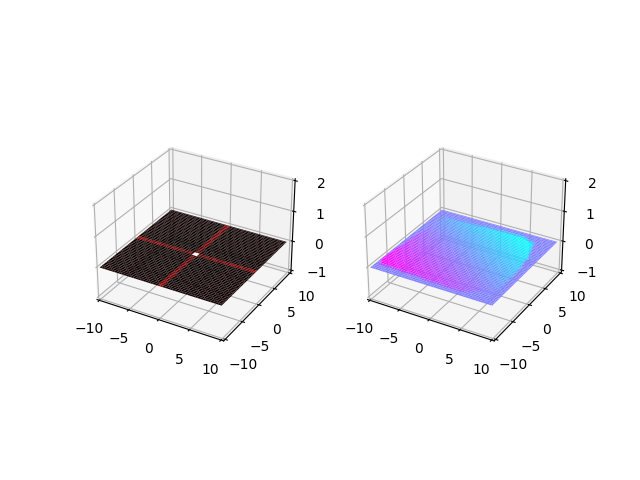

In [29]:
%matplotlib widget

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"})

print("Predicted maximum:", Z[np.unravel_index(z.argmax(), z.shape)], "at", np.unravel_index(z.argmax(), z.shape))
print("Actual maximum:", Z.max(), "at", np.unravel_index(Z.argmax(), Z.shape))

df = pd.DataFrame(list(product(range(100), range(100))), columns=["i", "j"])

df["x"] = X[0, df["i"]]
df["y"] = Y[df["j"], 0]
df["z"] = Z[df["i"], df["j"]]

pred = model.predict(df[["x", "y"]])

sum = np.sum((pred - df["z"])**2)
rmse = np.sqrt(sum / len(df["z"]))

print("RMSE:", rmse)

axs[0].plot_surface(X, Y, Z, cmap="hot")
axs[1].plot_surface(X, Y, z, cmap="cool")

axs[0].set_xlim(*xy_range[0])
axs[0].set_ylim(*xy_range[1])
axs[0].set_zlim(*z_range)
axs[1].set_xlim(*xy_range[0])
axs[1].set_ylim(*xy_range[1])
axs[1].set_zlim(*z_range)

plt.show()

In [30]:
warnings.simplefilter('ignore')

for obj in list(objectives.keys()):
    xy_range = objectives[obj]["bounds"]

    X = np.arange(*xy_range[0], ((xy_range[0][1] - xy_range[0][0]) / 100))
    Y = np.arange(*xy_range[1], ((xy_range[1][1] - xy_range[1][0]) / 100))
    X, Y = np.meshgrid(X, Y)
    Z = objectives[obj]["func"](X, Y)

    z_range = (np.floor(np.min(Z)) - 1, np.ceil(np.max(Z)) + 1)

    df = pd.DataFrame(np.random.randint(100, size=(m, 2)))

    df.columns = ["i", "j"]

    df["x"] = X[0, df["i"]]
    df["y"] = Y[df["j"], 0]
    df["z"] = Z[df["i"], df["j"]] + ran_err(m, 0.05)

    for idx in range(1, iterations + 1):
        krnl = RBF(length_scale=1)
        model = GaussianProcessRegressor(kernel=krnl, normalize_y=False, random_state=3, alpha=0.001)

        tmp_df = pd.DataFrame(np.random.randint(100, size=(n, 2)))

        tmp_df.columns = ["i", "j"]

        tmp_df["x"] = X[0, tmp_df["i"]]
        tmp_df["y"] = Y[tmp_df["j"], 0]
        tmp_df["z"] = Z[tmp_df["i"], tmp_df["j"]] + ran_err(n, 0.05) + sys_err(n, Z[tmp_df["i"], tmp_df["j"]])

        model.fit(tmp_df[["x", "y"]], tmp_df["z"])

        pred = model.predict(tmp_df[["x", "y"]])

        z = griddata((tmp_df["x"], tmp_df["y"]), pred, (X.T, Y.T), method="linear", fill_value=z_range[0])

        tmp_df = pd.DataFrame(list(product(range(100), range(100))), columns=["i", "j"])

        tmp_df["x"] = X[0, tmp_df["i"]]
        tmp_df["y"] = Y[tmp_df["j"], 0]
        tmp_df["z"] = Z[tmp_df["i"], tmp_df["j"]] + ran_err(10000, 0.05)

        mag = z[tmp_df["i"], tmp_df["j"]]

        p = mag - z.min() + laplace_alpha

        p = np.where(p > np.percentile(p, percentile), p, 0)

        p /= p.sum()

        tmp_df = tmp_df.loc[np.random.choice(tmp_df.index, size=m, p=p, replace=False)]

        df = pd.concat([df, tmp_df], ignore_index=True)

    krnl = RBF(length_scale=1)
    model = GaussianProcessRegressor(kernel=krnl, normalize_y=False, random_state=3, alpha=0.001)

    model.fit(df[["x", "y"]], df["z"])

    pred = model.predict(df[["x", "y"]])

    z = griddata((df["x"], df["y"]), pred, (X.T, Y.T), method="linear", fill_value=(z_range[0] + 1))

    print(f"{obj}:", percentileofscore(Z.flatten(), Z[np.unravel_index(z.argmax(), z.shape)]))

ackley: 95.185
beale: 96.02
bird: 99.94
booth: 67.38
bukin4: 66.655
bukin6: 94.19
carromtable: 99.735
chichinadze: 94.72
crossfunc: 52.795
crossintray: 99.47500000000001
crosslegtable: 86.77
crownedcross: 98.305
cube: 69.505
easom: 50.035000000000004
eggholder: 98.505
gaussian_min_max: 99.295
giunta: 72.505
goldsteinprice: 87.52
griewank: 65.215
helicalvally_min_max: 97.66
himmelblau: 88.12
holdertable: 98.42
leon: 86.49
levi13: 76.51
logarithmic_min_max: 98.64
matyas: 97.405
mccormick: 86.85000000000001
modschaffer1: 96.315
modschaffer2: 39.885
modschaffer3: 71.925
modschaffer4: 99.765
penholder: 93.395
perlin: 99.3
rastrigin: 91.565
rosenbrock: 90.505
schweffel: 99.965
sinenvsin: 37.005
sixhumpcamel: 87.16
testtubeholder: 98.89
threehumpcamel: 83.06
zettl: 92.96000000000001
